# Kaggle Home Credit Default Risk - First LightGBM

In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import gc
import datetime as dt
import time
from datetime import datetime
from sklearn.preprocessing import LabelEncoder

In [2]:
app_train = pd.read_csv('../data/application_train.csv')
print('application_train data shape: ', app_train.shape)

app_test = pd.read_csv('../data/application_test.csv')
print('application_test data shape: ', app_test.shape)

df_ssub = pd.read_csv('../data/sample_submission.csv')
print('sample_submission data shape: ', df_ssub.shape)

application_train data shape:  (307511, 122)
application_test data shape:  (48744, 121)
sample_submission data shape:  (48744, 2)


In [3]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [4]:
# one-hot encoding of categorical variables
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 239)


In [5]:
train_labels = app_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Add the target back in
app_train['TARGET'] = train_labels

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 239)


In [6]:
# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243

# Replace the anomalous values with nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

# Test set
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print('There are %d anomalies in the test data out of %d entries' % (app_test["DAYS_EMPLOYED_ANOM"].sum(), len(app_test)))

There are 9274 anomalies in the test data out of 48744 entries


In [7]:
# Find the correlation of the positive days since birth and target
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
# app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

In [8]:
# Make a new dataframe for polynomial features
poly_features = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = app_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]

# imputer for handling missing values
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy = 'median')

poly_target = poly_features['TARGET']

poly_features = poly_features.drop(columns = ['TARGET'])

# Need to impute missing values
poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)

from sklearn.preprocessing import PolynomialFeatures
                                  
# Create the polynomial object with specified degree
poly_transformer = PolynomialFeatures(degree = 3)

In [9]:
# Train the polynomial features
poly_transformer.fit(poly_features)

# Transform the features
poly_features = poly_transformer.transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape)

Polynomial Features shape:  (307511, 35)


In [10]:
# Create a dataframe of the features 
poly_features = pd.DataFrame(poly_features, 
                             columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                           'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Add in the target
poly_features['TARGET'] = poly_target

# Find the correlations with the target
poly_corrs = poly_features.corr()['TARGET'].sort_values()

# Display most negative and most positive
print(poly_corrs.head(10))
print(poly_corrs.tail(5))

EXT_SOURCE_2 EXT_SOURCE_3                -0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189605
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH     -0.181283
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172282
EXT_SOURCE_1 EXT_SOURCE_2                -0.166625
EXT_SOURCE_1 EXT_SOURCE_3                -0.164065
EXT_SOURCE_2                             -0.160295
EXT_SOURCE_2 DAYS_BIRTH                  -0.156873
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.156867
Name: TARGET, dtype: float64
DAYS_BIRTH     -0.078239
DAYS_BIRTH^2   -0.076672
DAYS_BIRTH^3   -0.074273
TARGET          1.000000
1                    NaN
Name: TARGET, dtype: float64


In [11]:
# Put test features into dataframe
poly_features_test = pd.DataFrame(poly_features_test, 
                                  columns = poly_transformer.get_feature_names(['EXT_SOURCE_1', 'EXT_SOURCE_2', 
                                                                                'EXT_SOURCE_3', 'DAYS_BIRTH']))

# Merge polynomial features into training dataframe
poly_features['SK_ID_CURR'] = app_train['SK_ID_CURR']
app_train_poly = app_train.merge(poly_features, on = 'SK_ID_CURR', how = 'left')

# Merge polnomial features into testing dataframe
poly_features_test['SK_ID_CURR'] = app_test['SK_ID_CURR']
app_test_poly = app_test.merge(poly_features_test, on = 'SK_ID_CURR', how = 'left')

# Align the dataframes
app_train_poly, app_test_poly = app_train_poly.align(app_test_poly, join = 'inner', axis = 1)

# Print out the new shapes
print('Training data with polynomial features shape: ', app_train_poly.shape)
print('Testing data with polynomial features shape:  ', app_test_poly.shape)

Training data with polynomial features shape:  (307511, 275)
Testing data with polynomial features shape:   (48744, 275)


In [12]:
# Add Domain Knowledge Features to train
app_train_domain = app_train.copy()
app_test_domain = app_test.copy()

app_train_domain['CREDIT_INCOME_PERCENT'] = app_train_domain['AMT_CREDIT'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['ANNUITY_INCOME_PERCENT'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_INCOME_TOTAL']
app_train_domain['CREDIT_TERM'] = app_train_domain['AMT_ANNUITY'] / app_train_domain['AMT_CREDIT']
app_train_domain['DAYS_EMPLOYED_PERCENT'] = app_train_domain['DAYS_EMPLOYED'] / app_train_domain['DAYS_BIRTH']

In [13]:
# Add Domain Knowledge Features to test
app_test_domain['CREDIT_INCOME_PERCENT'] = app_test_domain['AMT_CREDIT'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['ANNUITY_INCOME_PERCENT'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_INCOME_TOTAL']
app_test_domain['CREDIT_TERM'] = app_test_domain['AMT_ANNUITY'] / app_test_domain['AMT_CREDIT']
app_test_domain['DAYS_EMPLOYED_PERCENT'] = app_test_domain['DAYS_EMPLOYED'] / app_test_domain['DAYS_BIRTH']

In [14]:
# Merge Domain Knowledge Features into training dataframe
app_train_poly_n_domain = app_train_poly.merge(app_train_domain, how='left')

# Merge Domain Knowledge Features into testing dataframe
app_test_poly_n_domain = app_test_poly.merge(app_test_domain, how='left')

# Align the dataframes
app_train_poly_n_domain, app_test_poly_n_domain = app_train_poly_n_domain.align(app_test_poly_n_domain, join = 'inner', axis = 1)

# Print out the new shapes
print('Training data with polynomial features shape: ', app_train_poly_n_domain.shape)
print('Testing data with polynomial features shape:  ', app_test_poly_n_domain.shape)

Training data with polynomial features shape:  (307511, 283)
Testing data with polynomial features shape:   (48744, 283)


In [15]:
# from Features Importance RandomForestClassifier
selected_features = ['EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_2^2 EXT_SOURCE_3',
 'DAYS_ID_PUBLISH',
 'DAYS_REGISTRATION',
 'EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_2 EXT_SOURCE_3^2',
 'ANNUITY_INCOME_PERCENT',
 'EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH',
 'SK_ID_CURR',
 'EXT_SOURCE_1 EXT_SOURCE_2',
 'CREDIT_TERM',
 'DAYS_EMPLOYED_PERCENT',
 'CREDIT_INCOME_PERCENT',
 'AMT_ANNUITY',
 'DAYS_EMPLOYED',
 'EXT_SOURCE_1 EXT_SOURCE_2^2',
 'EXT_SOURCE_1 EXT_SOURCE_3 DAYS_BIRTH',
 'EXT_SOURCE_3^2 DAYS_BIRTH',
 'EXT_SOURCE_1 EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_3 DAYS_BIRTH',
 'EXT_SOURCE_2 DAYS_BIRTH^2',
 'EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_1^2 EXT_SOURCE_2',
 'EXT_SOURCE_2^2',
 'DAYS_LAST_PHONE_CHANGE',
 'EXT_SOURCE_2^2 DAYS_BIRTH',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'AMT_CREDIT',
 'EXT_SOURCE_3 DAYS_BIRTH^2',
 'EXT_SOURCE_2_y',
 'EXT_SOURCE_2^3',
 'EXT_SOURCE_2_x',
 'EXT_SOURCE_2',
 'REGION_POPULATION_RELATIVE',
 'EXT_SOURCE_1^2 DAYS_BIRTH',
 'EXT_SOURCE_1 EXT_SOURCE_3^2',
 'DAYS_BIRTH',
 'EXT_SOURCE_1 DAYS_BIRTH',
 'DAYS_BIRTH^2',
 'DAYS_BIRTH_x',
 'DAYS_BIRTH_y',
 'EXT_SOURCE_1 DAYS_BIRTH^2',
 'DAYS_BIRTH^3',
 'AMT_INCOME_TOTAL',
 'EXT_SOURCE_1^2 EXT_SOURCE_3',
 'AMT_GOODS_PRICE',
 'HOUR_APPR_PROCESS_START',
 'EXT_SOURCE_3_y',
 'EXT_SOURCE_3',
 'EXT_SOURCE_3^2',
 'EXT_SOURCE_3^3',
 'EXT_SOURCE_3_x',
 'OWN_CAR_AGE',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'EXT_SOURCE_1_x',
 'EXT_SOURCE_1_y',
 'EXT_SOURCE_1^2',
 'EXT_SOURCE_1^3',
 'EXT_SOURCE_1',
 'TOTALAREA_MODE',
 'LIVINGAREA_MEDI',
 'LIVINGAREA_AVG',
 'LIVINGAREA_MODE',
 'YEARS_BEGINEXPLUATATION_MODE',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BEGINEXPLUATATION_MEDI',
 'CNT_FAM_MEMBERS',
 'APARTMENTS_AVG',
 'APARTMENTS_MEDI',
 'LANDAREA_AVG',
 'APARTMENTS_MODE',
 'LANDAREA_MEDI',
 'LANDAREA_MODE',
 'BASEMENTAREA_AVG',
 'BASEMENTAREA_MODE',
 'BASEMENTAREA_MEDI',
 'YEARS_BUILD_AVG',
 'YEARS_BUILD_MODE',
 'NONLIVINGAREA_MEDI',
 'COMMONAREA_AVG',
 'YEARS_BUILD_MEDI',
 'LIVINGAPARTMENTS_MODE',
 'NONLIVINGAREA_AVG',
 'COMMONAREA_MEDI',
 'COMMONAREA_MODE',
 'LIVINGAPARTMENTS_AVG',
 'LIVINGAPARTMENTS_MEDI',
 'NONLIVINGAREA_MODE',
 'CNT_CHILDREN',
 'ENTRANCES_AVG',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'ENTRANCES_MEDI',
 'ENTRANCES_MODE',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'REGION_RATING_CLIENT',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'REGION_RATING_CLIENT_W_CITY',
 'FLOORSMAX_AVG',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'FLOORSMAX_MEDI',
 'CODE_GENDER_F',
 'FLOORSMAX_MODE',
 'FLOORSMIN_AVG',
 'CODE_GENDER_M']

In [21]:
from sklearn.preprocessing import MinMaxScaler, Imputer

# Drop the target from the training data
if 'TARGET' in app_train_poly_n_domain:
    train = app_train_poly_n_domain[selected_features].drop(columns = ['SK_ID_CURR', 'TARGET'])
else:
    train = app_train_poly_n_domain[selected_features].drop(columns = ['SK_ID_CURR']).copy()

    
# Feature names
features = list(train.columns)

# Copy of the testing data
# Remove the ids and target
test = app_test_poly_n_domain[selected_features].drop(columns = ['SK_ID_CURR']).copy()

# Extract the ids
train_ids = app_train_poly_n_domain['SK_ID_CURR']
test_ids = app_test_poly_n_domain['SK_ID_CURR']

# Median imputation of missing values
imputer = Imputer(strategy = 'median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(train)

# Transform both training and testing data
train = imputer.transform(train)
test = imputer.transform(app_test_poly_n_domain[selected_features].drop(columns = ['SK_ID_CURR']))

# Repeat with the scaler
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (307511, 105)
Testing data shape:  (48744, 105)


##### Training / Predictions

In [23]:
#X_train = app_train.drop(columns=['TARGET'])
X_train = train
y_train = train_labels
X_test = test

print('Training LGBM model...')
ltrain = lgb.Dataset(X_train, label = y_train)

params = {}
params['metric'] = 'auc'
params['max_depth'] = 1000
params['num_leaves'] = 32
params['feature_fraction'] = .85
params['bagging_fraction'] = .95
params['bagging_freq'] = 8
params['learning_rate'] = 0.0025
params['verbosity'] = 0
params['n_jobs'] = -1

lgb_model = lgb.train(params, ltrain, verbose_eval=0, num_boost_round=2930)

from sklearn.model_selection import cross_val_score
#print(cross_val_score(lgb_model, X_train, y_train))

print('Making predictions and praying for good results...')
y_pred = lgb_model.predict(X_test)

# app_test['TARGET'] = y_pred
# app_test['TARGET'] = app_test['TARGET'].apply(lambda x: abs(x))

# Make the submission dataframe
submission = pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': y_pred})
submission['TARGET'] = submission['TARGET'].apply(lambda x: abs(x))

print('Saving predictions...')
# results = app_test[df_ssub.columns]
assert submission.shape == df_ssub.shape
submission.to_csv('../submissions/lightgbm_{}.csv'.format(datetime.now().strftime('%Y%m%d_%H%M%S')), index=False, float_format='%.4f')
print('Done!')

Training LGBM model...
Making predictions and praying for good results...
Saving predictions...
Done!


## Model Interpretation: Feature Importances

In [50]:
def plot_feature_importances(df, n=15):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (20, 50))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:n]))), 
            df['importance_normalized'].head(n), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:n]))))
    ax.set_yticklabels(df['feature'].head(n))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df

In [51]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

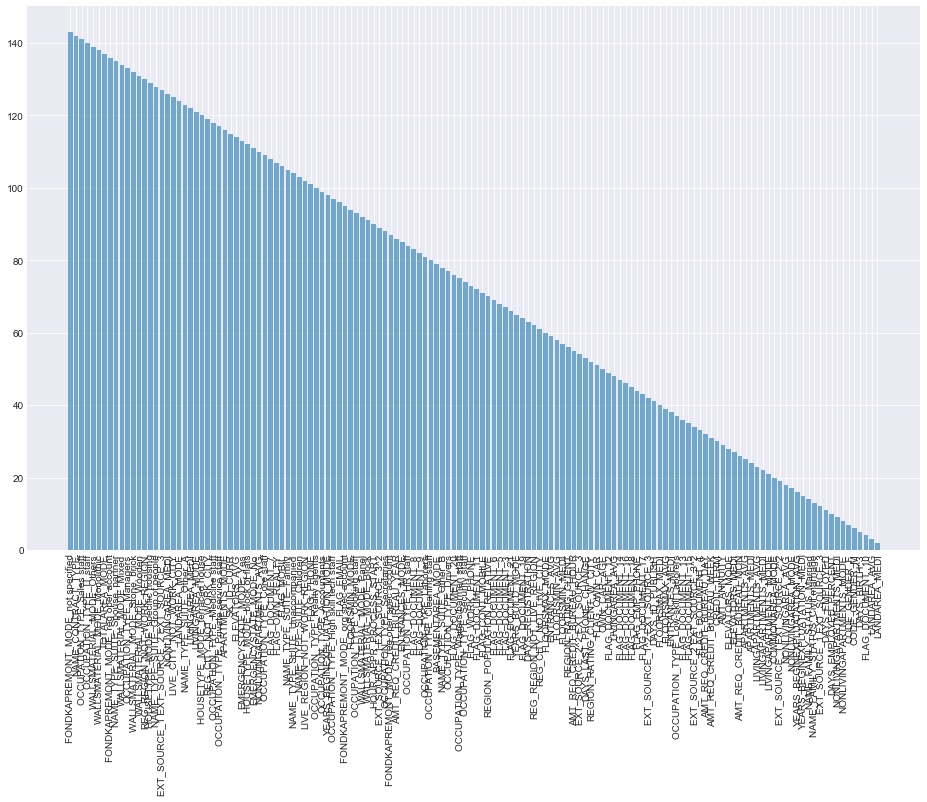

In [62]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

x_col_all = list(app_test_poly_n_domain.columns)

lr = LinearRegression()
rfe = RFE(lr)
rfe.fit(X_train, y_train)

plt.figure(figsize=(16, 10))

y_val22 = [x[0] for x in [x for x in sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), x_col_all), reverse=True) if x[0] > 1]]
x_val22 = [x[1] for x in [x for x in sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), x_col_all), reverse=True) if x[0] > 1]]

x22 = np.array(range(len(x_val22)))
plt.xticks(x22, x_val22, rotation=90)
plt.bar(x22, y_val22, align='center', alpha=0.6)
plt.show()


# plt.figure(figsize=(20,20))
# cormat = X_train.sort_values('Désignation_article').corr()
# sns.heatmap(cormat)

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.7min finished


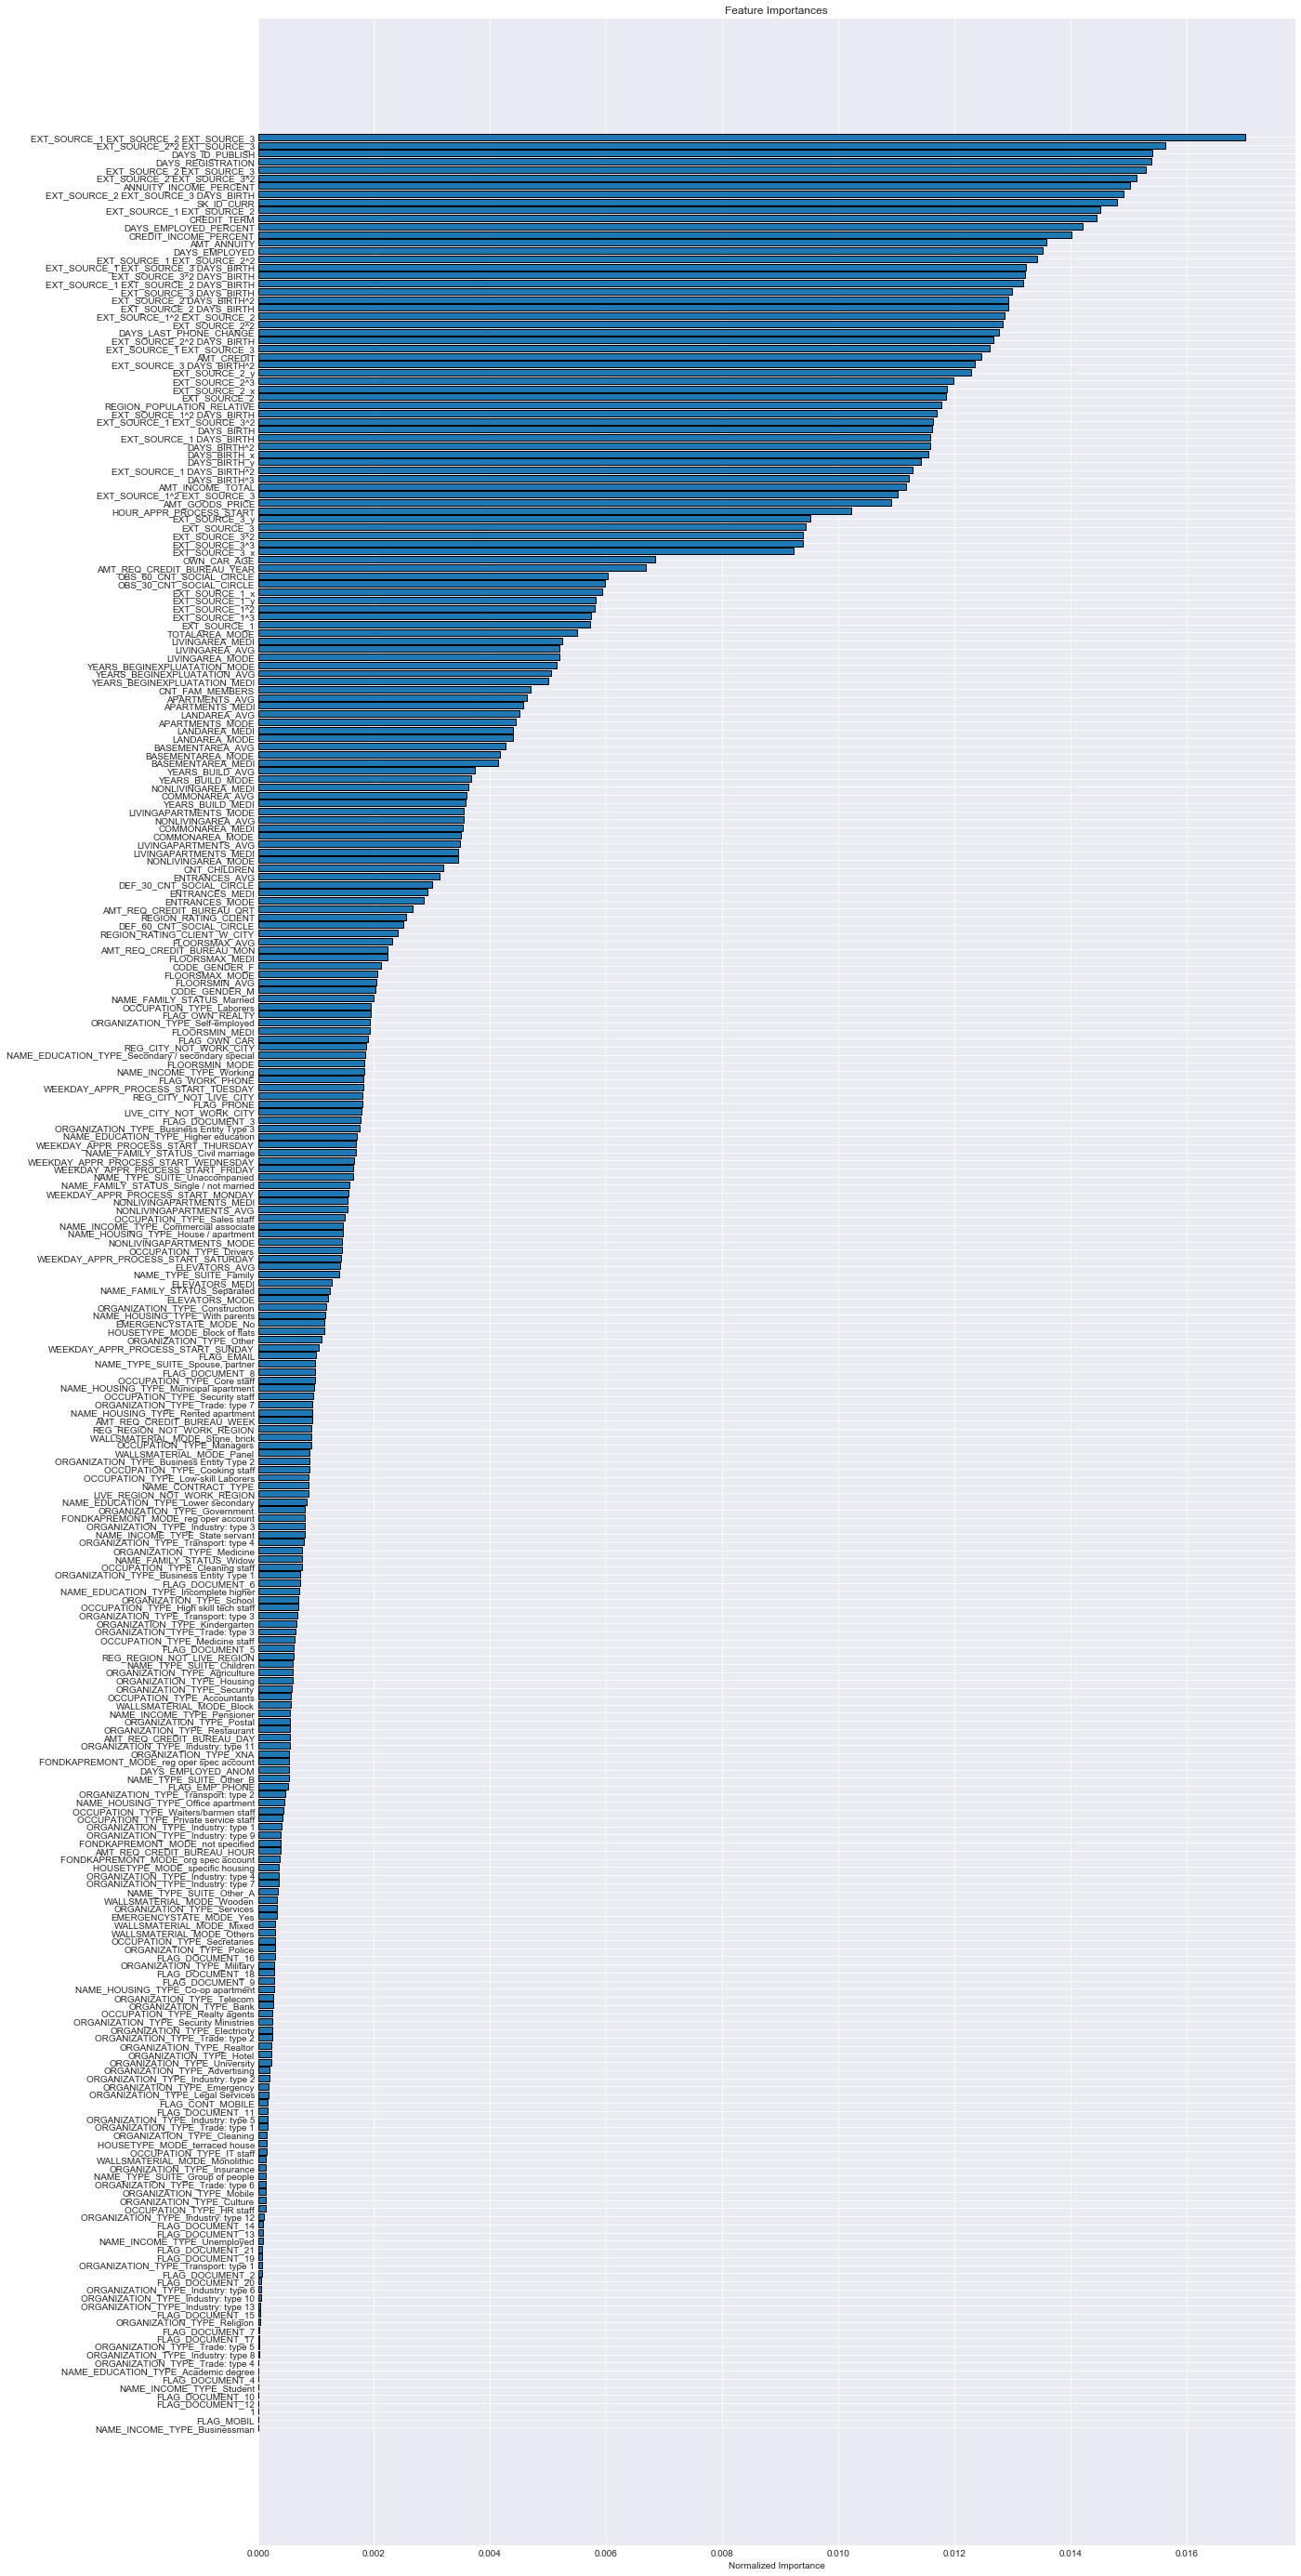

In [55]:
from sklearn.ensemble import RandomForestClassifier

# Make the random forest classifier
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)

# Train on the training data
random_forest.fit(train, train_labels)

# Extract feature importances
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

feature_importances_sorted = plot_feature_importances(feature_importances, n=283)

In [69]:
list(feature_importances_sorted[feature_importances_sorted['importance'] > 0.002].feature.unique())

['EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_2^2 EXT_SOURCE_3',
 'DAYS_ID_PUBLISH',
 'DAYS_REGISTRATION',
 'EXT_SOURCE_2 EXT_SOURCE_3',
 'EXT_SOURCE_2 EXT_SOURCE_3^2',
 'ANNUITY_INCOME_PERCENT',
 'EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH',
 'SK_ID_CURR',
 'EXT_SOURCE_1 EXT_SOURCE_2',
 'CREDIT_TERM',
 'DAYS_EMPLOYED_PERCENT',
 'CREDIT_INCOME_PERCENT',
 'AMT_ANNUITY',
 'DAYS_EMPLOYED',
 'EXT_SOURCE_1 EXT_SOURCE_2^2',
 'EXT_SOURCE_1 EXT_SOURCE_3 DAYS_BIRTH',
 'EXT_SOURCE_3^2 DAYS_BIRTH',
 'EXT_SOURCE_1 EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_3 DAYS_BIRTH',
 'EXT_SOURCE_2 DAYS_BIRTH^2',
 'EXT_SOURCE_2 DAYS_BIRTH',
 'EXT_SOURCE_1^2 EXT_SOURCE_2',
 'EXT_SOURCE_2^2',
 'DAYS_LAST_PHONE_CHANGE',
 'EXT_SOURCE_2^2 DAYS_BIRTH',
 'EXT_SOURCE_1 EXT_SOURCE_3',
 'AMT_CREDIT',
 'EXT_SOURCE_3 DAYS_BIRTH^2',
 'EXT_SOURCE_2_y',
 'EXT_SOURCE_2^3',
 'EXT_SOURCE_2_x',
 'EXT_SOURCE_2',
 'REGION_POPULATION_RELATIVE',
 'EXT_SOURCE_1^2 DAYS_BIRTH',
 'EXT_SOURCE_1 EXT_SOURCE_3^2',
 'DAYS_BIRTH',
 'EXT_SOURC